In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import argparse
import multiprocessing as mp

In [2]:
os.chdir('../../data')

In [3]:
Au3_genome_hapA = list(SeqIO.parse('Au3_CHR_hapA_v3.fasta', 'fasta'))
Au3_genome_hapB = list(SeqIO.parse('Au3_CHR_hapB_v3.fasta', 'fasta'))
Au3_genome = Au3_genome_hapA + Au3_genome_hapB

In [12]:
def calculate_dinucleotide_frequency(seqrecords):
    seq_id = seqrecords.id
    seq = str(seqrecords.seq)
    #Turn to upper case
    seq = seq.upper()
    dinucleotide_freq = {seq_id: {}}
    dinucleotide_types = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
    total_dinucleotides = 0
    for i in range(len(seq) - 1):
        if seq[i:i+2] in dinucleotide_types:
            total_dinucleotides += 1
            # Count the number of each dinucleotide
            dinucleotide_freq[seq_id][seq[i:i+2]] = dinucleotide_freq[seq_id].get(seq[i:i+2], 0) + 1
    
    sum_A = seq.count('A')
    sum_C = seq.count('C')
    sum_G = seq.count('G')
    sum_T = seq.count('T')
    expect_dinucleotide_freq = {}
    #for dinucleotide in dinucleotide_types:
    #    expect_dinucleotide_freq[dinucleotide] = ((seq.count(dinucleotide[0]) ) * (seq.count(dinucleotide[1]) )) / ((sum_A + sum_C + sum_G + sum_T) * (sum_A + sum_C + sum_G + sum_T))

    for dinucleotide in dinucleotide_types:
       # dinucleotide_freq[seq_id][dinucleotide] = dinucleotide_freq[seq_id].get(dinucleotide, 0) / total_dinucleotides
        dinucleotide_freq[seq_id][dinucleotide] = dinucleotide_freq[seq_id].get(dinucleotide, 0) / (expect_dinucleotide_freq[dinucleotide] *total_dinucleotides)
   
    return dinucleotide_freq

In [5]:
def calculate_dinucleotide_ratio(seqrecords):
    seq_id = seqrecords.id
    seq = str(seqrecords.seq)
    # Convert to uppercase and validate
    sequence = seq.upper()
    #Drop Ns
    sequence = re.sub('N', '', sequence)
    valid_bases = set('ATGC')
    dinucleotide_freq = {seq_id: {}}
    dinucleotide_types = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
    
    # Calculate mononucleotide frequencies
    seq_length = len(sequence)
    mono_freq = {
        'A': sequence.count('A') / seq_length,
        'T': sequence.count('T') / seq_length,
        'G': sequence.count('G') / seq_length,
        'C': sequence.count('C') / seq_length
    }
    
    # Calculate expected dinucleotide frequencies
    expected_freq = {}
    for base1 in mono_freq:
        for base2 in mono_freq:
            dinuc = base1 + base2
            # Expected frequency is the product of individual frequencies
            expected_freq[dinuc] = mono_freq[base1] * mono_freq[base2]
    
    # Calculate observed dinucleotide frequencies
    observed_freq = {}
    for i in range(len(sequence) - 1):
        dinuc = sequence[i:i+2]
        observed_freq[dinuc] = observed_freq.get(dinuc, 0) + 1
    
    # Convert counts to frequencies
    total_dinucs = len(sequence) - 1
    for dinuc in observed_freq:
        observed_freq[dinuc] /= total_dinucs
    
    # Calculate observed/expected ratios
    ratio = {}
    ratio = {seq_id: {}}
    for dinuc in observed_freq:
        ratio[seq_id][dinuc] = observed_freq[dinuc] / expected_freq[dinuc]
    return ratio

In [35]:
#This for calculating double strand DNA
import re
from collections import Counter

def calculate_dinucleotide_ratio_DS(seqrecords):
    seq_id = seqrecords.id
    seq = str(seqrecords.seq)
    # Convert sequence to uppercase and remove 'N's
    sequence = re.sub(r'N', '', seq.upper())

    # Define complementary base pairs
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}

    # Calculate mononucleotide frequencies
    seq_length = len(sequence)
    mono_freq = {
        'A': sequence.count('A') ,
        'T': sequence.count('T'),
        'G': sequence.count('G') ,
        'C': sequence.count('C') 
    }

    observed_count = {}
    for i in range(len(sequence) - 1):
        dinuc = sequence[i:i+2]
        observed_count[dinuc] = observed_count.get(dinuc, 0) + 1

    ratio = {seq_id: {}}

    # Complementary dinucleotide frequencies
    for dinuc in observed_count:
        X, Y = dinuc
        comp_dinuc = complement[Y] + complement[X]  # Complementary dinucleotide
        tmp1 = 2*(observed_count.get(dinuc) + observed_count.get(comp_dinuc))*seq_length
        tmp2 = (mono_freq.get(X) +mono_freq.get(Y))*(mono_freq.get(complement[Y]) + mono_freq.get(complement[X]))
        ratio[seq_id][dinuc] =tmp1/tmp2


    return ratio



In [44]:
def find_strange_dinucleotide(seqrecords):
    seq_id = seqrecords.id
    seq = str(seqrecords.seq)
    #Turn to upper case
    seq = seq.upper()
    dinucleotide_types = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
    for i in range(len(seq) - 1):
        dinucleotide = seq[i:i+2]
        if dinucleotide not in dinucleotide_types:
            print(f"Strange dinucleotide {dinucleotide} found in {seq_id} at position {i}")
    return

In [36]:
dinucleotide_freq_dict_ratio = {}

def update_dict(result):
    dinucleotide_freq_dict_ratio.update(result)

pool = mp.Pool(mp.cpu_count())

for result in pool.map(calculate_dinucleotide_ratio, Au3_genome):
    update_dict(result)

pool.close()
pool.join()


In [37]:
dinucleotide_freq_dict_ratio_DS = {}

def update_dict(result):
    dinucleotide_freq_dict_ratio_DS.update(result)

pool = mp.Pool(mp.cpu_count())

for result in pool.map(calculate_dinucleotide_ratio_DS, Au3_genome):
    update_dict(result)

pool.close()
pool.join()

In [38]:
dinucleotide_freq_dict_ratio_DS

{'APSI_AU3_HapA_CHR01': {'CA': 1.0881537123670173,
  'AA': 1.1450995261248706,
  'AC': 0.7190935619072825,
  'CC': 1.354231917749562,
  'CT': 0.92521590652548,
  'TA': 0.7248806935255124,
  'TT': 1.1450995261248706,
  'AT': 0.9445745879988274,
  'TC': 0.9369055019575135,
  'TG': 1.0881537123670173,
  'GT': 0.7190935619072825,
  'AG': 0.92521590652548,
  'GA': 0.9369055019575135,
  'GG': 1.354231917749562,
  'GC': 0.9533442412780119,
  'CG': 0.18845761670084463},
 'APSI_AU3_HapA_CHR02': {'AC': 0.7150840131140619,
  'CC': 1.358944936056307,
  'CT': 0.9203046461615982,
  'TA': 0.7245189623401975,
  'AA': 1.1471785419339415,
  'TC': 0.9352505620885548,
  'CA': 1.0817026067206283,
  'TT': 1.1471785419339415,
  'TG': 1.0817026067206283,
  'GT': 0.7150840131140619,
  'AT': 0.9428743291130546,
  'AG': 0.9203046461615982,
  'GA': 0.9352505620885548,
  'GC': 0.9507837888051024,
  'GG': 1.358944936056307,
  'CG': 0.18595451480292616},
 'APSI_AU3_HapA_CHR03': {'CC': 1.3610512135021129,
  'CT': 0.9

In [7]:
dinucleotide_freq_dict_ratio

{'APSI_AU3_HapA_CHR01': {'CA': 1.2096122354713148,
  'AA': 1.1434837891423497,
  'AC': 0.8000997364709326,
  'CC': 1.3540108029647726,
  'CT': 1.0271465415560708,
  'TA': 0.7248873021618317,
  'TT': 1.146692952185465,
  'AT': 0.9445831995537829,
  'TC': 1.0409567219908562,
  'TG': 1.20889680379392,
  'GT': 0.7981383659094581,
  'AG': 1.029224222898139,
  'GA': 1.0413994869970704,
  'GG': 1.3544525083817702,
  'GC': 0.9533444143005442,
  'CG': 0.18845765090403446},
 'APSI_AU3_HapA_CHR02': {'AC': 0.7974376414159094,
  'CC': 1.3598944233826447,
  'CT': 1.027235052110084,
  'TA': 0.7245199565135823,
  'AA': 1.1472295510747936,
  'TC': 1.0437435842128988,
  'CA': 1.2062661583657117,
  'TT': 1.1471210645297936,
  'TG': 1.207245396948485,
  'GT': 0.7980688492525795,
  'AT': 0.9428756229101971,
  'AG': 1.026156925003473,
  'GA': 1.042995018569196,
  'GC': 0.9507852671941237,
  'GG': 1.3579918198103875,
  'CG': 0.18595480394659517},
 'APSI_AU3_HapA_CHR03': {'CC': 1.3607516872333179,
  'CT': 1.0

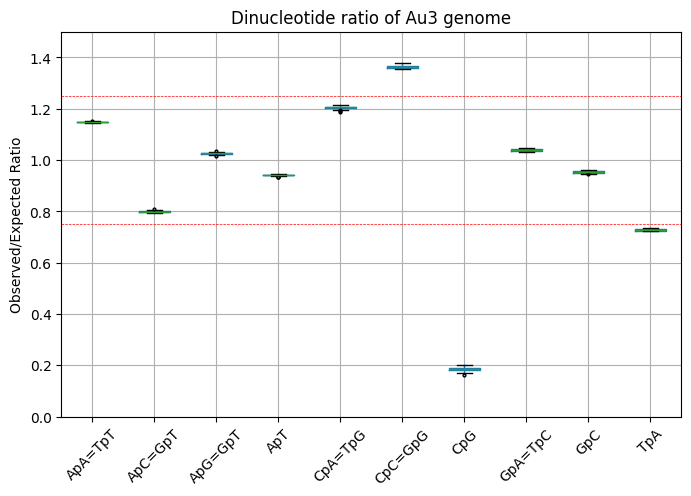

In [42]:
#Plot the dinucleotide ratio
ratio_df = pd.DataFrame(dinucleotide_freq_dict_ratio).T
from matplotlib import rcParams
rcParams['svg.fonttype'] = 'none'
ratio_df = ratio_df.fillna(0)
ratio_df = ratio_df.sort_index()
ratio_df = ratio_df.reindex(sorted(ratio_df.columns), axis=1)
ratio_df = ratio_df.reindex(sorted(ratio_df.index), axis=0)
ratio_df.columns = ['ApA', 'ApC', 'ApG', 'ApT', 'CpA', 'CpC', 'CpG', 'CpT', 'GpA', 'GpC', 'GpG', 'GpT', 'TpA', 'TpC', 'TpG', 'TpT']
ratio_df2 = ratio_df[['ApA', 'ApC', 'ApG', 'ApT', 'CpA','CpC', 'CpG', 'GpA','GpC', 'TpA']]
ratio_df2.columns = ['ApA=TpT', 'ApC=GpT', 'ApG=GpT', 'ApT', 'CpA=TpG', 'CpC=GpG','CpG','GpA=TpC','GpC','TpA']

#Plot the boxplot
plt.figure(figsize=(8,5))
ratio_df2.boxplot(rot=45, flierprops=dict(marker='o', markersize=2))
plt.axhline(y=0.75, color='r', linestyle='--', linewidth=0.5)
plt.axhline(y=1.25, color='r', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.ylim(0,1.5)
plt.ylabel('Observed/Expected Ratio')
plt.title('Dinucleotide ratio of Au3 genome')
plt.savefig("/mnt/c/Users/lzy55/Downloads/Dinucleotide.svg", format="svg", bbox_inches="tight")
plt.show()

,ApA,ApC,ApG,ApT,CpA,CpC,CpG,CpT,GpA,GpC,GpG,GpT,TpA,TpC,TpG,TpT
APSI_AU3_HapA_CHR01,1.143484,0.800100,1.029224,0.944583,1.209612,1.354011,0.188458,1.027147,1.041399,0.953344,1.354453,0.798138,0.724887,1.040957,1.208897,1.146693
APSI_AU3_HapA_CHR02,1.147230,0.797438,1.026157,0.942876,1.206266,1.359894,0.185955,1.027235,1.042995,0.950785,1.357992,0.798069,0.724520,1.043744,1.207245,1.147121
APSI_AU3_HapA_CHR03,1.147474,0.795091,1.028717,0.942620,1.203879,1.360752,0.184529,1.027656,1.043318,0.955180,1.361339,0.794696,0.725332,1.043214,1.204887,1.148377
APSI_AU3_HapA_CHR04,1.145893,0.797635,1.029831,0.942648,1.207111,1.362274,0.182473,1.027303,1.042243,0.950659,1.363259,0.795638,0.725078,1.041591,1.204237,1.148889
APSI_AU3_HapA_CHR05,1.146877,0.799495,1.023328,0.943551,1.206770,1.362916,0.187667,1.022164,1.040103,0.953290,1.362879,0.796671,0.724066,1.038542,1.209950,1.150294
APSI_AU3_HapA_CHR06,1.146420,0.798632,1.027819,0.941950,1.204085,1.360741,0.184130,1.028720,1.038867,0.954319,1.359583,0.800428,0.729200,1.040826,1.204895,1.145585
APSI_AU3_HapA_CHR07,1.146662,0.798925,1.025112,0.944533,1.207537,1.360104,0.193681,1.024087,1.040485,0.953115,1.357635,0.797474,0.723520,1.038525,1.208784,1.148633
APSI_AU3_HapA_CHR08,1.147918,0.795829,1.029488,0.941775,1.203207,1.364657,0.181859,1.030525,1.045915,0.949459,1.360570,0.795012,0.724874,1.043025,1.204211,1.147668
APSI_AU3_HapA_CHR09,1.148564,0.795442,1.025482,0.942726,1.201991,1.367397,0.183354,1.027960,1.040672,0.954090,1.364328,0.797074,0.728401,1.040809,1.203873,1.146355
APSI_AU3_HapA_CHR10,1.144815,0.806039,1.023895,0.943306,1.213214,1.353936,0.188799,1.024684,1.030767,0.955939,1.354303,0.808220,0.728976,1.033456,1.212178,1.143383


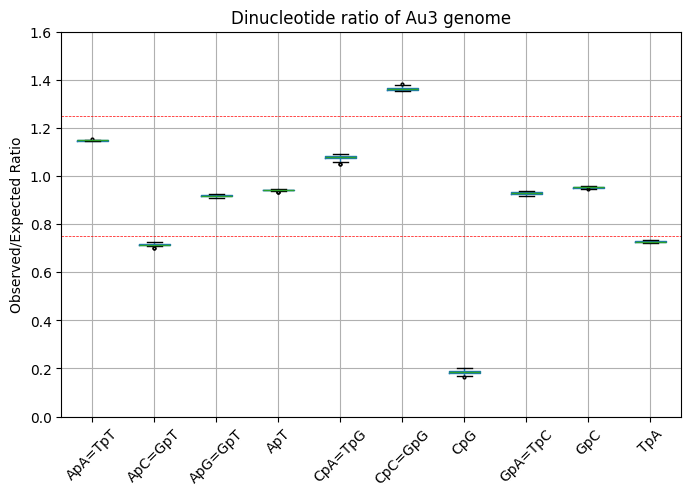

In [45]:
ratio_df = pd.DataFrame(dinucleotide_freq_dict_ratio_DS).T
from matplotlib import rcParams
rcParams['svg.fonttype'] = 'none'
ratio_df = ratio_df.fillna(0)
ratio_df = ratio_df.sort_index()
ratio_df = ratio_df.reindex(sorted(ratio_df.columns), axis=1)
ratio_df = ratio_df.reindex(sorted(ratio_df.index), axis=0)
ratio_df.columns = ['ApA', 'ApC', 'ApG', 'ApT', 'CpA', 'CpC', 'CpG', 'CpT', 'GpA', 'GpC', 'GpG', 'GpT', 'TpA', 'TpC', 'TpG', 'TpT']
ratio_df2 = ratio_df[['ApA', 'ApC', 'ApG', 'ApT', 'CpA','CpC', 'CpG', 'GpA','GpC', 'TpA']]
ratio_df2.columns = ['ApA=TpT', 'ApC=GpT', 'ApG=GpT', 'ApT', 'CpA=TpG', 'CpC=GpG','CpG','GpA=TpC','GpC','TpA']

#Plot the boxplot
plt.figure(figsize=(8,5))
ratio_df2.boxplot(rot=45, flierprops=dict(marker='o', markersize=2))
plt.axhline(y=0.75, color='r', linestyle='--', linewidth=0.5)
plt.axhline(y=1.25, color='r', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.ylim(0, 1.6)
plt.ylabel('Observed/Expected Ratio')
plt.title('Dinucleotide ratio of Au3 genome')
plt.savefig("/mnt/c/Users/lzy55/Downloads/Dinucleotide_v2.svg", format="svg", bbox_inches="tight")
plt.show()

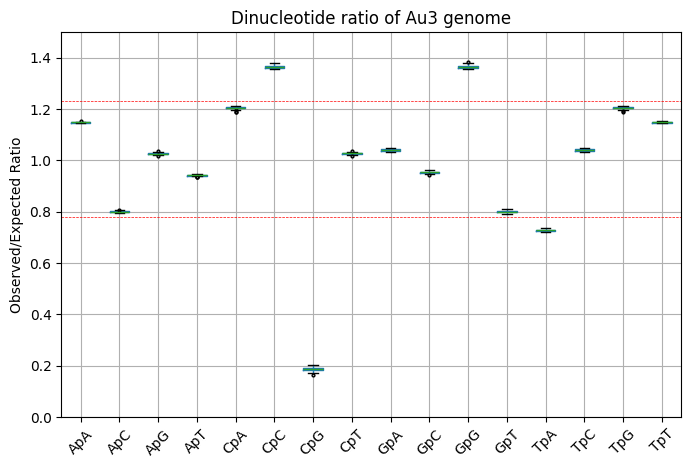

In [23]:
ratio_df = pd.DataFrame(dinucleotide_freq_dict_ratio).T
ratio_df = ratio_df.fillna(0)
ratio_df = ratio_df.sort_index()
ratio_df = ratio_df.reindex(sorted(ratio_df.columns), axis=1)
ratio_df = ratio_df.reindex(sorted(ratio_df.index), axis=0)
ratio_df.columns = ['ApA', 'ApC', 'ApG', 'ApT', 'CpA', 'CpC', 'CpG', 'CpT', 'GpA', 'GpC', 'GpG', 'GpT', 'TpA', 'TpC', 'TpG', 'TpT']
ratio_df2 = ratio_df[['ApA', 'ApC', 'ApG', 'ApT', 'CpA','CpC', 'CpG', 'GpA','GpC', 'TpA']]
ratio_df2.columns = ['ApA=TpT', 'ApC=GpT', 'ApG=GpT', 'ApT', 'CpA=TpG', 'CpC=GpG','CpG','GpA=TpC','GpC','TpA']

#Plot the boxplot
plt.figure(figsize=(8,5))
ratio_df.boxplot(rot=45, flierprops=dict(marker='o', markersize=2))
plt.axhline(y=0.78, color='r', linestyle='--', linewidth=0.5)
plt.axhline(y=1.23, color='r', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.ylim(0,1.5)
plt.ylabel('Observed/Expected Ratio')
plt.title('Dinucleotide ratio of Au3 genome')
plt.show()

In [11]:


dinucleotide_freq_dict = {}

def update_dict(result):
    dinucleotide_freq_dict.update(result)

pool = mp.Pool(mp.cpu_count())

for result in pool.map(calculate_dinucleotide_frequency, Au3_genome):
    update_dict(result)

pool.close()
pool.join()

# Print the combined dictionary
print(dinucleotide_freq_dict)

NameError: name 'calculate_dinucleotide_frequency' is not defined

In [10]:
#Plot the dinucleotide frequency
dinucleotide_freq_df = pd.DataFrame(dinucleotide_freq_dict).T
dinucleotide_freq_df = dinucleotide_freq_df.fillna(0)
dinucleotide_freq_df = dinucleotide_freq_df.reindex(sorted(dinucleotide_freq_df.columns), axis=1)
dinucleotide_freq_df = dinucleotide_freq_df.reindex(sorted(dinucleotide_freq_df.index), axis=0)
#Convert to percentage
dinucleotide_freq_df = dinucleotide_freq_df 

#Replace the coloumn names with the full name, ApA, ApC, ApG, ApT, CpA, CpC, CpG, CpT, GpA, GpC, GpG, GpT, TpA, TpC, TpG, TpT
dinucleotide_freq_df.columns = ['ApA', 'ApC', 'ApG', 'ApT', 'CpA', 'CpC', 'CpG', 'CpT', 'GpA', 'GpC', 'GpG', 'GpT', 'TpA', 'TpC', 'TpG', 'TpT']
#Plot the heatmap

#Draw as line plot, with each chromosome as a line, and each dinucleotide as a point
# Plot as box plot
fig, ax = plt.subplots(figsize=(6, 3))
dinucleotide_freq_df.boxplot(ax=ax, rot=45, flierprops=dict(marker='o', markersize=2))
#Add a horizontal line at y=1
plt.axhline(y=0.78, color='r', linestyle='--', linewidth=0.5)
plt.axhline(y=1.23, color='r', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.ylabel('Observed/Expected dinucleotide frequency', fontsize=6)
#Change ylabl size
plt.yticks(fontsize=8)
plt.title('Dinucleotide frequency across chromosomes', fontsize=6)
plt.tight_layout()
plt.show()


NameError: name 'dinucleotide_freq_dict' is not defined

In [76]:
#Get the composition of GC content for in 1kb windows
def calculate_GC_content(seqrecords, window_size):
    seq_id = seqrecords.id
    seq = str(seqrecords.seq)
    #Turn to upper case
    seq = seq.upper()
    #Remove 'N'
    seq = re.sub('N', '', seq)
    GC_window = []
    for i in range(0, len(seq), window_size):
        window = seq[i:i+window_size]
        GC_content = (window.count('G') + window.count('C')) / len(window)
        GC_window.append(GC_content)
    seq_size = len(seq)
    GC_freq_bins = pd.cut(GC_window, bins=np.arange(0, 1, 0.05), right=True)
    GC_freq_bins = GC_freq_bins.value_counts().sort_index()
    #Convert to density
    GC_freq_bins = GC_freq_bins * window_size * 100 / seq_size
    GC_freq_bins = GC_freq_bins.reset_index()
    GC_freq_bins.columns = ['GC_content', 'Density']
    GC_freq_bins['GC_content'] = GC_freq_bins['GC_content'].apply(lambda x: x.mid * 100)
    GC_freq_bins['seq_id'] = seq_id
    return GC_freq_bins

In [ ]:
#Convert the list of GC content to a dictionary


In [60]:
GC_freq_dict = []

def update_dict(result):
    GC_freq_dict.append(result)

pool = mp.Pool(mp.cpu_count())

for result in pool.map(calculate_GC_content, Au3_genome):
    update_dict(result)

pool.close()
pool.join()

In [61]:
GC_freq_list = [item for sublist in GC_freq_dict for item in sublist]

In [25]:
#Get the whole genome size
whole_genome_size = sum([len(str(seq.seq)) for seq in Au3_genome])


In [26]:
whole_genome_size

2056048748

In [62]:
#Assign the GC_freq_list to bins
GC_freq_bins = pd.cut(GC_freq_list, bins=np.arange(0, 1, 0.05), right=True)
GC_freq_bins = GC_freq_bins.value_counts().sort_index()
#Convert to density
GC_freq_bins = GC_freq_bins * 10000 * 100 / whole_genome_size
GC_freq_bins = GC_freq_bins.reset_index()
GC_freq_bins.columns = ['GC_content', 'Density']
GC_freq_bins['GC_content'] = GC_freq_bins['GC_content'].apply(lambda x: x.mid * 100)

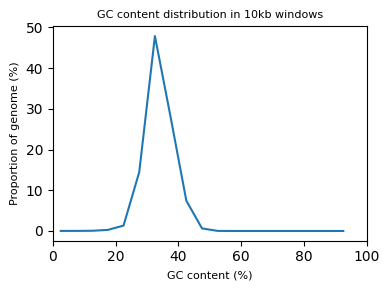

In [67]:
#Plot the GC content
fig, ax = plt.subplots(figsize=(4, 3))
#plot as line plot
plt.plot(GC_freq_bins['GC_content'], GC_freq_bins['Density'], linestyle='-')
plt.xlabel('GC content (%)', fontsize=8)
plt.ylabel('Proportion of genome (%)', fontsize=8)
plt.title('GC content distribution in 10kb windows', fontsize=8)
plt.x_ticks = np.arange(0, 100, 10)
plt.xlim(0, 100)
plt.tight_layout()
plt.show()


In [55]:
test0 = calculate_GC_content(test)

In [68]:
Au3_genome_old = list(SeqIO.parse('GCA_902702905.1_Austropuccinia_psidii_genomic.fna', 'fasta'))

In [69]:
GC_freq_dict_old = []

def update_dict(result):
    GC_freq_dict_old.append(result)

pool = mp.Pool(mp.cpu_count())

for result in pool.map(calculate_GC_content,Au3_genome_old):
    update_dict(result)

pool.close()
pool.join()

In [70]:
GC_freq_list_old = [item for sublist in GC_freq_dict_old for item in sublist]
old_genome_size = sum([len(str(seq.seq)) for seq in Au3_genome_old])

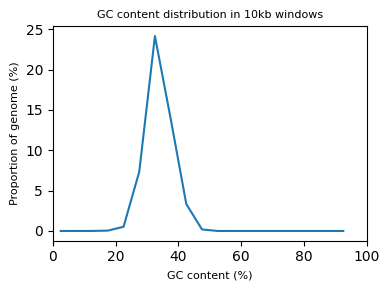

In [74]:
GC_freq_bins = pd.cut(GC_freq_list_old, bins=np.arange(0, 1, 0.05), right=True)
GC_freq_bins = GC_freq_bins.value_counts().sort_index()
#Convert to density
GC_freq_bins = GC_freq_bins * 10000 * 100 / whole_genome_size
GC_freq_bins = GC_freq_bins.reset_index()
GC_freq_bins.columns = ['GC_content', 'Density']
GC_freq_bins['GC_content'] = GC_freq_bins['GC_content'].apply(lambda x: x.mid * 100)
fig, ax = plt.subplots(figsize=(4, 3))
#plot as line plot
plt.plot(GC_freq_bins['GC_content'], GC_freq_bins['Density'], linestyle='-')
plt.xlabel('GC content (%)', fontsize=8)
plt.ylabel('Proportion of genome (%)', fontsize=8)
plt.title('GC content distribution in 10kb windows', fontsize=8)
plt.x_ticks = np.arange(0, 100, 10)
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

In [77]:
#Plot the GC content
Au3_v3_GC_content = pd.DataFrame()
for seq in Au3_genome:
    tmp = calculate_GC_content(seq, 100)
    Au3_v3_GC_content = pd.concat([Au3_v3_GC_content, tmp])

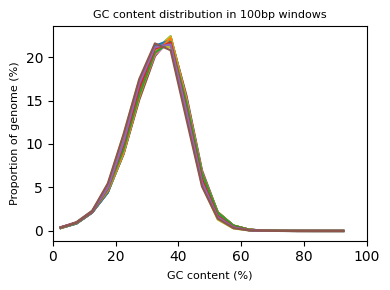

In [ ]:
#Plot the GC content by chromosome
fig, ax = plt.subplots(figsize=(4, 3))
for seq_id in Au3_v3_GC_content['seq_id'].unique():
    tmp = Au3_v3_GC_content[Au3_v3_GC_content['seq_id'] == seq_id]
    plt.plot(tmp['GC_content'], tmp['Density'], linestyle='-', label=seq_id)
plt.xlabel('GC content (%)', fontsize=8)
plt.ylabel('Proportion of genome (%)', fontsize=8)
plt.title('GC content distribution in 100bp sliding windows', fontsize=8)
plt.x_ticks = np.arange(0, 100, 10)
plt.xlim(0, 100)
#plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [5]:
AU3_cds = list(SeqIO.parse('TE/Au3_deduplicate.cds', 'fasta'))

In [64]:
#Reappend the cds to the genome if the gene is not a multiple of 3
def append_cds_to_genome(old_cds):
    new_cds = []
    for cds in old_cds:
        cds_id = cds.id
        cds_seq = str(cds.seq)
        if len(cds_seq) % 3 != 0:
            cds_seq = cds_seq[:-(len(cds_seq) % 3)]
        cds_seq = Seq(cds_seq)
        cds_record = SeqRecord(cds_seq, id=cds_id)
        new_cds.append(cds_record)
    return new_cds

In [65]:
AU3_new_cds = append_cds_to_genome(AU3_cds)

In [43]:
#Calculate the codon usage for each gene
def codon_usage(gene):
    gene_id = gene.id
    gene_seq = str(gene.seq)
    gene_seq = gene_seq.upper()
    codon_freq = {}
    #If the gene is not a multiple of 3, remove the last codon
    if len(gene_seq) % 3 != 0:
        gene_seq = gene_seq[:-(len(gene_seq) % 3)]
    for i in range(0, len(gene_seq), 3):
        codon = gene_seq[i:i+3]
        codon_freq[codon] = codon_freq.get(codon, 0) + 1
    total_codons = sum(codon_freq.values())
    codon_freq = {k: v / total_codons for k, v in codon_freq.items()}
    return {gene_id: codon_freq}

In [44]:
#Calculate the codon usage for each gene
codon_usage_dict = {}
def update_dict(result):
    codon_usage_dict.update(result)

pool = mp.Pool(mp.cpu_count())

for result in pool.map(codon_usage, AU3_cds):
    update_dict(result)

pool.close()
pool.join()



In [45]:
# Check length of MK676_001063-T1
seq_length = None
for seq_record in AU3_cds:
	if seq_record.id == 'MK676_001063-T1':
		seq_length = len(seq_record.seq)
		break
seq_length

919

In [46]:
codon_usage_dict['MK676_001063-T1']

{'ATG': 0.026143790849673203,
 'GAT': 0.013071895424836602,
 'AAA': 0.08496732026143791,
 'ATT': 0.029411764705882353,
 'AAT': 0.058823529411764705,
 'GAG': 0.029411764705882353,
 'GCT': 0.00980392156862745,
 'AAC': 0.016339869281045753,
 'TCA': 0.026143790849673203,
 'CCA': 0.03594771241830065,
 'TTA': 0.029411764705882353,
 'ACC': 0.00980392156862745,
 'TTT': 0.0196078431372549,
 'TCT': 0.016339869281045753,
 'CAC': 0.0196078431372549,
 'ATA': 0.032679738562091505,
 'AGA': 0.029411764705882353,
 'GGC': 0.006535947712418301,
 'CCT': 0.013071895424836602,
 'GTT': 0.006535947712418301,
 'GAA': 0.08823529411764706,
 'ACA': 0.02287581699346405,
 'TTC': 0.02287581699346405,
 'GAC': 0.0392156862745098,
 'AGT': 0.013071895424836602,
 'CAA': 0.026143790849673203,
 'GTC': 0.0032679738562091504,
 'AAG': 0.0392156862745098,
 'GCA': 0.02287581699346405,
 'TGG': 0.029411764705882353,
 'GGA': 0.0196078431372549,
 'GGT': 0.006535947712418301,
 'TAT': 0.026143790849673203,
 'ATC': 0.01307189542483660

In [59]:
#Convert the dictionary to a dataframe
codon_usage_df = pd.DataFrame(codon_usage_dict).T
codon_usage_df = codon_usage_df.fillna(0)
codon_usage_df = codon_usage_df.reindex(sorted(codon_usage_df.columns), axis=1)
codon_usage_df = codon_usage_df.reindex(sorted(codon_usage_df.index), axis=0)
#Add a index column for the amino acid
#Make a dictionary of the codon and the corresponding amino acid
codon_to_aa = {
    'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
    'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
    'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',
    'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',
    'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
    'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
    'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
    'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
    'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
    'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
    'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
    'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
}

In [ ]:
#Calculate the dinucleotide frequency for the coding sequences


,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
MK675_000001-T1,0.043210,0.012346,0.024691,0.074074,0.000000,0.000000,0.006173,0.024691,0.012346,0.018519,...,0.000000,0.030864,0.000000,0.006173,0.018519,0.018519,0.018519,0.000000,0.024691,0.049383
MK675_000002-T1,0.028249,0.011299,0.011299,0.016949,0.000000,0.028249,0.005650,0.039548,0.005650,0.016949,...,0.011299,0.011299,0.000000,0.000000,0.005650,0.011299,0.016949,0.016949,0.028249,0.033898
MK675_000003-T1,0.016129,0.018817,0.029570,0.018817,0.024194,0.016129,0.005376,0.024194,0.013441,0.018817,...,0.005376,0.029570,0.000000,0.010753,0.010753,0.000000,0.010753,0.018817,0.013441,0.029570
MK675_000004-T1,0.024793,0.016529,0.008264,0.074380,0.008264,0.024793,0.000000,0.024793,0.000000,0.008264,...,0.000000,0.008264,0.000000,0.016529,0.016529,0.008264,0.033058,0.000000,0.008264,0.008264
MK675_000005-T1,0.063492,0.015873,0.000000,0.063492,0.000000,0.015873,0.000000,0.031746,0.000000,0.000000,...,0.000000,0.063492,0.015873,0.000000,0.000000,0.047619,0.031746,0.000000,0.031746,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MK676_026285-T2,0.056886,0.044910,0.016467,0.046407,0.016467,0.017964,0.001497,0.022455,0.011976,0.007485,...,0.005988,0.016467,0.001497,0.011976,0.011976,0.008982,0.010479,0.022455,0.005988,0.025449
MK676_026285-T3,0.055649,0.018550,0.020236,0.038786,0.013491,0.015177,0.006745,0.028668,0.018550,0.008432,...,0.006745,0.013491,0.000000,0.011804,0.015177,0.013491,0.016863,0.030354,0.006745,0.018550
MK676_026286-T1,0.014563,0.029126,0.014563,0.009709,0.000000,0.004854,0.000000,0.000000,0.004854,0.038835,...,0.000000,0.009709,0.000000,0.000000,0.004854,0.000000,0.004854,0.004854,0.009709,0.004854
MK676_026287-T1,0.074074,0.027778,0.027778,0.027778,0.009259,0.046296,0.000000,0.037037,0.000000,0.018519,...,0.000000,0.018519,0.000000,0.018519,0.000000,0.009259,0.055556,0.027778,0.009259,0.009259


In [57]:
codon_usage_df.columns

Index(['AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT', 'AGA', 'AGC',
       'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT', 'CAA', 'CAC', 'CAG', 'CAT',
       'CCA', 'CCC', 'CCG', 'CCT', 'CGA', 'CGC', 'CGG', 'CGT', 'CTA', 'CTC',
       'CTG', 'CTT', 'GAA', 'GAC', 'GAG', 'GAT', 'GCA', 'GCC', 'GCG', 'GCT',
       'GGA', 'GGC', 'GGG', 'GGT', 'GTA', 'GTC', 'GTG', 'GTT', 'TAA', 'TAC',
       'TAG', 'TAT', 'TCA', 'TCC', 'TCG', 'TCT', 'TGA', 'TGC', 'TGG', 'TGT',
       'TTA', 'TTC', 'TTG', 'TTT'],
      dtype='object')

In [56]:
codon_usage_df.index

Index(['MK675_000001-T1', 'MK675_000002-T1', 'MK675_000003-T1',
       'MK675_000004-T1', 'MK675_000005-T1', 'MK675_000006-T1',
       'MK675_000007-T1', 'MK675_000008-T1', 'MK675_000010-T1',
       'MK675_000011-T1',
       ...
       'MK676_026282-T1', 'MK676_026282-T2', 'MK676_026283-T1',
       'MK676_026284-T1', 'MK676_026285-T1', 'MK676_026285-T2',
       'MK676_026285-T3', 'MK676_026286-T1', 'MK676_026287-T1',
       'MK676_026288-T1'],
      dtype='object', length=38160)

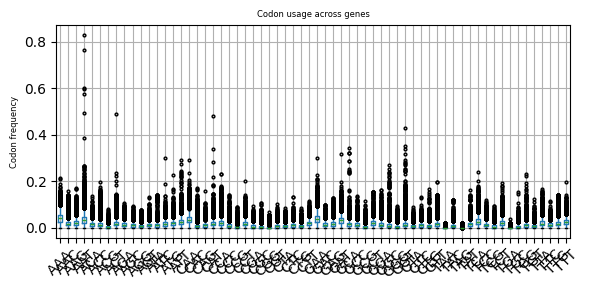

In [48]:
#Plot the codon usage, using box plot, with codons as x-axis, and genes as y-axis
fig, ax = plt.subplots(figsize=(6, 3))
codon_usage_df.boxplot(ax=ax, rot=45, flierprops=dict(marker='o', markersize=2))
plt.xticks(rotation=45)
plt.ylabel('Codon frequency', fontsize=6)
plt.title('Codon usage across genes', fontsize=6)
plt.tight_layout()
plt.show()


In [68]:
cds_dinucleotide_freq_dict = {}

def update_dict(result):
    cds_dinucleotide_freq_dict.update(result)

pool = mp.Pool(mp.cpu_count())

for result in pool.map(calculate_dinucleotide_frequency, AU3_new_cds):
    update_dict(result)

pool.close()
pool.join()


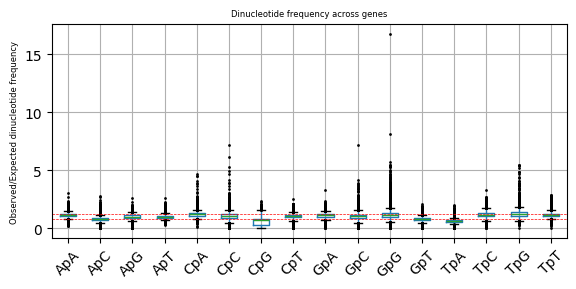

In [77]:
#cds_dinucleotide_freq_dict plot as box plot
cds_dinucleotide_freq_df = pd.DataFrame(cds_dinucleotide_freq_dict).T
cds_dinucleotide_freq_df = cds_dinucleotide_freq_df.fillna(0)
cds_dinucleotide_freq_df = cds_dinucleotide_freq_df.reindex(sorted(cds_dinucleotide_freq_df.columns), axis=1)
cds_dinucleotide_freq_df = cds_dinucleotide_freq_df.reindex(sorted(cds_dinucleotide_freq_df.index), axis=0)
cds_dinucleotide_freq_df.columns = ['ApA', 'ApC', 'ApG', 'ApT', 'CpA', 'CpC', 'CpG', 'CpT', 'GpA', 'GpC', 'GpG', 'GpT', 'TpA', 'TpC', 'TpG', 'TpT']
plt.figure(figsize=(6, 3))
cds_dinucleotide_freq_df.boxplot(rot=45, flierprops=dict(marker='o', markersize=1))
plt.xticks(rotation=45)

plt.axhline(y=0.78, color='r', linestyle='--', linewidth=0.5)
plt.axhline(y=1.23, color='r', linestyle='--', linewidth=0.5)
plt.ylabel('Observed/Expected dinucleotide frequency', fontsize=6)
plt.title('Dinucleotide frequency across genes', fontsize=6)
plt.tight_layout()
plt.show()

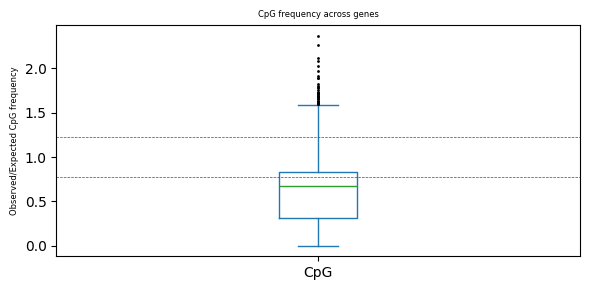

In [79]:
#Plot CpG dinucleotide frequency only
plt.figure(figsize=(6, 3))
cds_dinucleotide_freq_df['CpG'].plot(kind='box', flierprops=dict(marker='o', markersize=1))

plt.axhline(y=0.78, color='r', linestyle='--', linewidth=0.5)
plt.axhline(y=1.23, color='r', linestyle='--', linewidth=0.5)
plt.ylabel('Observed/Expected CpG frequency', fontsize=6)
plt.title('CpG frequency across genes', fontsize=6)
plt.tight_layout()
plt.show()


In [71]:
cds_dinucleotide_freq_df

,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
MK675_000001-T1,1.168166,0.710641,0.939625,0.994897,1.350217,1.149946,0.191658,1.054117,1.271257,1.277718,0.894402,0.521735,0.352359,1.102031,1.639738,1.341603
MK675_000002-T1,1.179526,1.039852,0.961913,0.823344,1.207570,0.849944,0.782356,1.173323,0.737466,1.293896,1.208049,0.765943,0.884332,0.829911,1.039494,1.222754
MK675_000003-T1,1.157738,0.899691,1.138308,0.821833,1.093471,1.067356,0.776294,1.047188,1.026081,1.049435,1.049046,0.883514,0.720906,0.982547,1.063211,1.225490
MK675_000004-T1,1.145396,0.713436,0.884115,1.087297,1.239126,1.063558,0.149059,1.229739,1.094619,1.416063,1.002762,0.539530,0.513446,1.069338,1.858380,1.032144
MK675_000005-T1,1.109460,0.735315,0.821822,1.140488,1.323566,0.789496,0.441189,1.122480,0.904005,1.176504,0.821822,1.140488,0.627268,1.428611,1.824781,0.633087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MK676_026285-T2,1.289855,0.789404,0.915165,0.896498,0.948420,1.028308,0.664716,1.225616,1.125548,0.805329,1.539011,0.743434,0.613393,1.347461,1.154977,1.042096
MK676_026285-T3,1.168064,0.839372,1.050032,0.929134,0.993257,1.019364,0.589271,1.221601,1.257731,0.689878,1.304012,0.808730,0.664589,1.342153,1.153434,0.986006
MK676_026286-T1,1.159562,0.869079,1.200488,0.838107,1.144288,0.968906,0.645291,1.220409,0.487698,1.386181,1.238003,0.592661,0.838107,0.915307,1.382876,1.120872
MK676_026287-T1,1.155020,0.919338,1.183024,0.783140,1.123636,1.320959,0.091063,0.990719,1.051577,0.819565,1.406179,0.819565,0.612892,0.896365,1.457005,1.415313


In [93]:
#Rename the genome name
Au3_genome_renamed = []
for seq in Au3_genome:
    seqid_old = seq.id
    seq_seq = seq.seq
    if '_ab' in seq.id:
        seqnew = 'Chr14B'
    elif 'HapA' in seqid_old:
        #Add A to the end of the chromosome name
        seqnew = seq.id + 'A'
        seqnew = seqnew.replace('APSI_AU3_HapA_CHR', 'Chr')
    elif 'HapB' in seqid_old:
        #Add B to the end of the chromosome name
        seqnew = seq.id + 'B'
        seqnew = seqnew.replace('APSI_AU3_HapB_CHR', 'Chr')
    Au3_genome_renamed.append(SeqRecord(seq=seq_seq, id=seqnew, name=seqid_old, description=''))

In [19]:
#Read TE sequences
TE = list(SeqIO.parse('TE/Au3_TE_merged.fna', 'fasta'))


In [20]:
#Remove TE sequences less than 2bp
TE = [seq for seq in TE if len(seq.seq) >= 2]


In [26]:
def calculate_TE_dinucleotide_frequency(seqrecords):
    seq_id = seqrecords.id
    seq = str(seqrecords.seq)
    #Turn to upper case
    seq = seq.upper()
    dinucleotide_freq = {seq_id: {}}
    dinucleotide_types = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
    total_dinucleotides = 0
    for i in range(len(seq) - 1):
        if seq[i:i+2] in dinucleotide_types:
            total_dinucleotides += 1
            # Count the number of each dinucleotide
            dinucleotide_freq[seq_id][seq[i:i+2]] = dinucleotide_freq[seq_id].get(seq[i:i+2], 0) + 1
    
    sum_A = seq.count('A')
    sum_C = seq.count('C')
    sum_G = seq.count('G')
    sum_T = seq.count('T')
    expect_dinucleotide_freq = {}
    for dinucleotide in dinucleotide_types:
        expect_dinucleotide_freq[dinucleotide] = ((seq.count(dinucleotide[0]) ) * (seq.count(dinucleotide[1]) ))/len(seq)

    for dinucleotide in dinucleotide_types:
        denominator = expect_dinucleotide_freq[dinucleotide]# * total_dinucleotides
        if denominator != 0:
            dinucleotide_freq[seq_id][dinucleotide] = dinucleotide_freq[seq_id].get(dinucleotide, 0)  / (denominator * total_dinucleotides)
        else:
            dinucleotide_freq[seq_id][dinucleotide] = 0
   
    return dinucleotide_freq

In [21]:
TE_dinucleotide_freq_dict = {}

def update_dict(result):
    TE_dinucleotide_freq_dict.update(result)

pool = mp.Pool(mp.cpu_count())

for result in pool.map(calculate_dinucleotide_ratio, TE):
    update_dict(result)

pool.close()
pool.join()
TE_dinucleotide_freq_df = pd.DataFrame(TE_dinucleotide_freq_dict).T
TE_dinucleotide_freq_df = TE_dinucleotide_freq_df.fillna(0)
TE_dinucleotide_freq_df = TE_dinucleotide_freq_df.reindex(sorted(TE_dinucleotide_freq_df.columns), axis=1)
TE_dinucleotide_freq_df = TE_dinucleotide_freq_df.reindex(sorted(TE_dinucleotide_freq_df.index), axis=0)
TE_dinucleotide_freq_df.columns = ['ApA', 'ApC', 'ApG', 'ApT', 'CpA', 'CpC', 'CpG', 'CpT', 'GpA', 'GpC', 'GpG', 'GpT', 'TpA', 'TpC', 'TpG', 'TpT']
#write the TE dinucleotide frequency to a file
TE_dinucleotide_freq_df.to_csv('TE_dinucleotide_freq.csv')

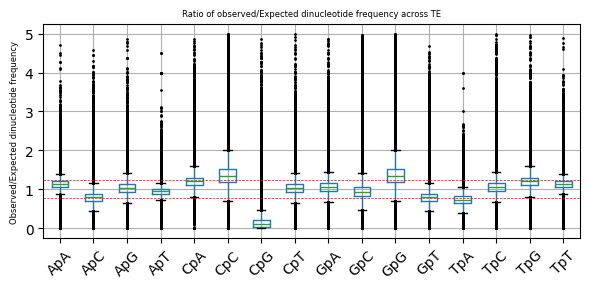

In [40]:
#Plot the dinucleotide frequency for TE
TE_dinucleotide_freq_df = pd.DataFrame(TE_dinucleotide_freq_dict).T
TE_dinucleotide_freq_df = TE_dinucleotide_freq_df.fillna(0)
TE_dinucleotide_freq_df = TE_dinucleotide_freq_df.reindex(sorted(TE_dinucleotide_freq_df.columns), axis=1)
TE_dinucleotide_freq_df = TE_dinucleotide_freq_df.reindex(sorted(TE_dinucleotide_freq_df.index), axis=0)
TE_dinucleotide_freq_df.columns = ['ApA', 'ApC', 'ApG', 'ApT', 'CpA', 'CpC', 'CpG', 'CpT', 'GpA', 'GpC', 'GpG', 'GpT', 'TpA', 'TpC', 'TpG', 'TpT']

#Only plot value less than 10
TE_dinucleotide_freq_df = TE_dinucleotide_freq_df[TE_dinucleotide_freq_df < 5]
plt.figure(figsize=(6, 3))
TE_dinucleotide_freq_df.boxplot(rot=45, flierprops=dict(marker='o', markersize=1))
plt.xticks(rotation=45)
plt.axhline(y=0.78, color='r', linestyle='--', linewidth=0.5)
plt.axhline(y=1.23, color='r', linestyle='--', linewidth=0.5)
plt.ylabel('Observed/Expected dinucleotide frequency', fontsize=6)
plt.title('Ratio of observed/Expected dinucleotide frequency across TE', fontsize=6)
plt.tight_layout()
plt.show()

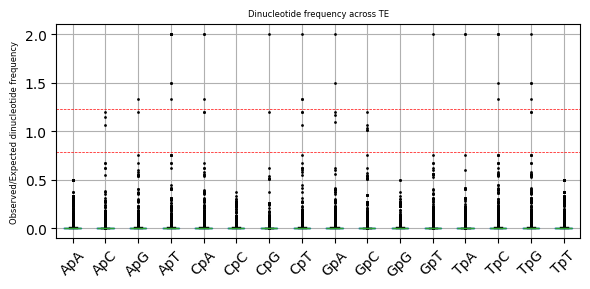

In [28]:
plt.figure(figsize=(6, 3))

TE_dinucleotide_freq_df.boxplot(rot=45, flierprops=dict(marker='o', markersize=1))
plt.xticks(rotation=45)
plt.axhline(y=0.78, color='r', linestyle='--', linewidth=0.5)
plt.axhline(y=1.23, color='r', linestyle='--', linewidth=0.5)
plt.ylabel('Observed/Expected dinucleotide frequency', fontsize=6)
plt.title('Dinucleotide frequency across TE', fontsize=6)
plt.tight_layout()
plt.show()

In [38]:
TE_dinucleotide_freq_df[TE_dinucleotide_freq_df['CpG'] >10]

,ApA,ApC,ApG,ApT,CpA,CpC,CpG,CpT,GpA,GpC,GpG,GpT,TpA,TpC,TpG,TpT
Chr02B:72484931-72485138,0.205437,0.000000,0.000000,1.265988,0.000000,0.000000,52.001214,0.000000,1.155583,0.000000,0.000000,0.993654,1.236547,1.324872,0.993654,0.928254
Chr04A:52876236-52877028,0.041043,0.000000,0.000000,1.213091,0.000000,0.000000,198.250316,0.610941,0.000000,0.000000,0.000000,1.221882,1.213091,1.221882,0.610941,0.954536
Chr05A:44978004-44978054,1.350257,0.000000,0.554570,0.806647,0.000000,0.000000,12.755102,0.000000,1.109139,0.000000,0.000000,0.579777,0.604985,2.319109,1.159555,1.370383
Chr05B:45131532-45131582,1.264969,0.000000,0.579777,0.907478,0.000000,0.000000,12.755102,0.000000,1.159555,0.000000,0.000000,0.554570,0.705816,2.218279,1.109139,1.253810
Chr05B:50704951-50704992,2.941750,0.000000,0.000000,0.336200,0.000000,0.000000,10.506250,0.000000,2.101250,0.000000,2.626562,0.420250,0.168100,1.681000,0.420250,1.412040
Chr07B:3556009-3556547,0.000000,0.000000,0.000000,1.197782,7.637678,0.000000,20.730841,0.000000,0.000000,0.000000,0.000000,1.197782,0.735480,1.197782,0.000000,1.032754
Chr08A:33096887-33096997,1.581157,0.909911,0.000000,0.237368,0.909911,0.000000,55.504587,0.000000,1.819823,0.000000,0.000000,0.000000,0.237368,1.206621,0.000000,2.046010
Chr09A:4508084-4508131,2.223229,0.000000,0.000000,0.205221,0.000000,0.000000,24.010870,0.000000,0.000000,0.000000,12.005435,0.923495,0.205221,1.846990,0.000000,1.633876
Chr10A:39180933-39181001,0.469489,0.000000,1.643213,1.251971,0.000000,0.000000,17.253731,0.000000,0.000000,0.000000,0.000000,1.643213,1.330220,1.643213,0.410803,0.860730
Chr11A:27215118-27215190,0.505288,0.715824,0.000000,1.252693,1.431649,0.000000,12.169014,0.507042,0.000000,0.000000,0.000000,1.521127,1.163215,1.267606,0.000000,0.950704


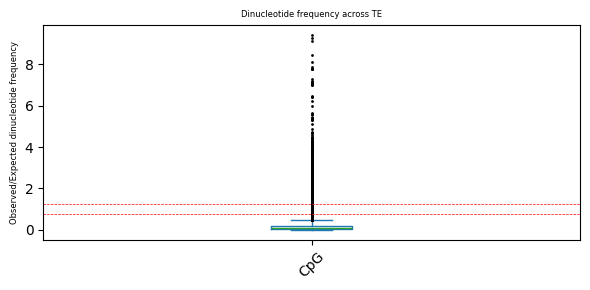

In [28]:
#Plot CpG dinucleotide frequency only
plt.figure(figsize=(6, 3))
#Only plot below 10
TE_dinucleotide_freq_df[TE_dinucleotide_freq_df['CpG'] < 10]['CpG'].plot(kind='box', flierprops=dict(marker='o', markersize=1))
#TE_dinucleotide_freq_df['CpG'].plot(kind='box', flierprops=dict(marker='o', markersize=1))
plt.xticks(rotation=45)
plt.axhline(y=0.78, color='r', linestyle='--', linewidth=0.5)
plt.axhline(y=1.23, color='r', linestyle='--', linewidth=0.5)
plt.ylabel('Observed/Expected dinucleotide frequency', fontsize=6)
plt.title('Dinucleotide frequency across TE', fontsize=6)
plt.tight_layout()
plt.show()

In [10]:
TE_dinucleotide_freq_df[TE_dinucleotide_freq_df['CpG'] > 10]

,ApA,ApC,ApG,ApT,CpA,CpC,CpG,CpT,GpA,GpC,GpG,GpT,TpA,TpC,TpG,TpT
Chr02B:72484931-72485138,0.205437,0.000000,0.000000,1.265988,0.000000,0.000000,52.001214,0.000000,1.155583,0.000000,0.000000,0.993654,1.236547,1.324872,0.993654,0.928254
Chr04A:52876236-52877028,0.041043,0.000000,0.000000,1.213091,0.000000,0.000000,198.250316,0.610941,0.000000,0.000000,0.000000,1.221882,1.213091,1.221882,0.610941,0.954536
Chr05A:44978004-44978054,1.350257,0.000000,0.554570,0.806647,0.000000,0.000000,12.755102,0.000000,1.109139,0.000000,0.000000,0.579777,0.604985,2.319109,1.159555,1.370383
Chr05B:45131532-45131582,1.264969,0.000000,0.579777,0.907478,0.000000,0.000000,12.755102,0.000000,1.159555,0.000000,0.000000,0.554570,0.705816,2.218279,1.109139,1.253810
Chr05B:50704951-50704992,2.941750,0.000000,0.000000,0.336200,0.000000,0.000000,10.506250,0.000000,2.101250,0.000000,2.626562,0.420250,0.168100,1.681000,0.420250,1.412040
Chr07B:3556009-3556547,0.000000,0.000000,0.000000,1.197782,7.637678,0.000000,20.730841,0.000000,0.000000,0.000000,0.000000,1.197782,0.735480,1.197782,0.000000,1.032754
Chr08A:33096887-33096997,1.581157,0.909911,0.000000,0.237368,0.909911,0.000000,55.504587,0.000000,1.819823,0.000000,0.000000,0.000000,0.237368,1.206621,0.000000,2.046010
Chr09A:4508084-4508131,2.223229,0.000000,0.000000,0.205221,0.000000,0.000000,24.010870,0.000000,0.000000,0.000000,12.005435,0.923495,0.205221,1.846990,0.000000,1.633876
Chr10A:39180933-39181001,0.469489,0.000000,1.643213,1.251971,0.000000,0.000000,17.253731,0.000000,0.000000,0.000000,0.000000,1.643213,1.330220,1.643213,0.410803,0.860730
Chr11A:27215118-27215190,0.505288,0.715824,0.000000,1.252693,1.431649,0.000000,12.169014,0.507042,0.000000,0.000000,0.000000,1.521127,1.163215,1.267606,0.000000,0.950704
